In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import math
import copy

# The deformation module library is not automatically installed yet, we need to add its path manually
import sys
sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import implicitmodules.torch as dm

torch.set_default_tensor_type(torch.FloatTensor)

dm.Utilities.set_compute_backend('torch')

In [2]:
# WIP
# On va merge les deux .pkl en un seul dictionnary
data_source = pickle.load(open("../../data/leafbasi.pkl", 'rb'))
data_target = pickle.load(open("../../data/leafbasit.pkl", 'rb'))

Dx = 0.
Dy = 0.
height_source = 38.
height_target = 100.

source = torch.tensor(data_source[1]).type(torch.get_default_dtype())
target = torch.tensor(data_target[1]).type(torch.get_default_dtype())

dec = 30.
smin, smax = torch.min(source[:, 1]), torch.max(source[:, 1])
sscale = height_source / (smax - smin)
source[:, 1] = Dy - sscale * (source[:, 1] - smax) + dec
source[:, 0] = Dx + sscale * (source[:, 0] - torch.mean(source[:, 0]))

tmin, tmax = torch.min(target[:, 1]), torch.max(target[:, 1])
tscale = height_target / (tmax - tmin)
target[:, 1] = - tscale * (target[:, 1] - tmax)
target[:, 0] = tscale * (target[:, 0] - torch.mean(target[:, 0]))

pos_source = source[source[:, 2] == 2, 0:2]
pos_source = torch.tensor(np.delete(pos_source.numpy(), 3, axis=0))
#pos_implicit0 = source[:, 0:2]
pos_implicit0 = source[source[:, 2] == 2, 0:2]
pos_implicit1 = source[source[:, 2] == 1, 0:2]
pos_target = target[target[:, 2] == 2, 0:2]

aabb = dm.Utilities.AABB.build_from_points(pos_target)
aabb.squared()

In [3]:
pos_implicit0.shape

torch.Size([52, 2])

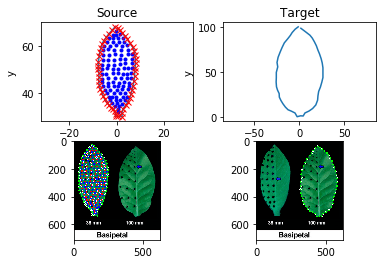

In [4]:
# Some plots
#%matplotlib qt5

plt.subplot(2, 2, 1)
plt.axis(aabb.totuple())
plt.title('Source')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '-')
plt.plot(pos_implicit1[:, 0].numpy(), pos_implicit1[:, 1].numpy(), '.b')
plt.plot(pos_implicit0[:, 0].numpy(), pos_implicit0[:, 1].numpy(), 'xr')
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.axis(aabb.totuple())
plt.title('Target')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(pos_target[:, 0].numpy(), pos_target[:, 1].numpy(), '-')
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.imshow(data_source[0])

plt.subplot(2, 2, 4)
plt.imshow(data_target[0])

plt.show()

In [5]:
# Setting up the modules

# Global translation module
global_translation = dm.DeformationModules.GlobalTranslation(2)

# Local translation module
sigma0 = 5.
nu0 = 0.01
coeff0 = 10.
implicit0 = dm.DeformationModules.ImplicitModule0(2, pos_implicit0.shape[0], sigma0, nu0, coeff0, gd=pos_implicit0.clone().requires_grad_())

# Elastic modules
sigma1 = 10.
nu1 = 0.01
coeff1 = 0.01
C = torch.zeros(pos_implicit1.shape[0], 2, 1)
K, L = 10, height_source
a, b = -2 / L ** 3, 3 / L ** 2
C[:, 1, 0] = (K * (a * (L - (pos_implicit1[:, 1] - dec) + Dy) ** 3  + b * (L - (pos_implicit1[:, 1] - dec) + Dy) ** 2))
C[:, 0, 0] = 1. * C[:, 1, 0]
th = 0. * math.pi * torch.ones(pos_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(t) for t in th])

implicit1 = dm.DeformationModules.ImplicitModule1(2, pos_implicit1.shape[0], sigma1, C, nu=nu1, coeff=coeff1, gd=(pos_implicit1.clone().requires_grad_(), R.clone().requires_grad_()))

In [6]:
source_deformable = dm.Models.DeformablePoints(pos_source)
target_deformable = dm.Models.DeformablePoints(pos_target)

In [7]:
# Setting up the model and start the fitting loop
#model = dm.Models.RegistrationModel([source_deformable], [implicit0], [dm.Attachment.VarifoldAttachment(2, [10., 100.], backend='torch')], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [global_translation, implicit0, implicit1], [dm.Attachment.VarifoldAttachment(2, [10., 100.], backend='torch')], lam=100.)
fitter = dm.Models.Fitter(model)

In [8]:
shoot_method = 'euler'
shoot_it = 10

In [9]:
costs = fitter.fit(target_deformable, 40, options={'shoot_method': shoot_method, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': tensor(0.), 'attach': tensor(1805267.)}


../../implicitmodules/torch/Models/optimizer_scipy.py:45: OptimizeWarning: Unknown solver options: shoot_method
  scipy_res = minimize(self.__evaluate(target, shoot_solver, shoot_it), x0, method=self.__scipy_method, jac=self.__need_grad, tol=tol, callback=_post_iteration_callback, options=options)


Time: 10.802225994000082
Iteration: 0
Costs
deformation=47.85377883911133
attach=483343.75
Total cost=483391.6037788391
Time: 13.891083220999917
Iteration: 1
Costs
deformation=30.42919158935547
attach=225050.296875
Total cost=225080.72606658936
Time: 20.008145856000056
Iteration: 2
Costs
deformation=21.571237564086914
attach=157992.671875
Total cost=158014.2431125641
Time: 23.08828865700002
Iteration: 3
Costs
deformation=20.347883224487305
attach=154464.75
Total cost=154485.0978832245
Time: 25.991981979000002
Iteration: 4
Costs
deformation=19.674747467041016
attach=148423.625
Total cost=148443.29974746704
Time: 29.014447503999918
Iteration: 5
Costs
deformation=19.758914947509766
attach=116917.1875
Total cost=116936.94641494751
Time: 32.11300126900005
Iteration: 6
Costs
deformation=28.69482421875
attach=76171.78125
Total cost=76200.47607421875
Time: 35.052138732
Iteration: 7
Costs
deformation=46.323524475097656
attach=47078.7109375
Total cost=47125.0344619751
Time: 37.96534597100003
Ite

In [10]:

intermediates = {}
deformed = model.compute_deformed(shoot_method, shoot_it, intermediates=intermediates)[0][0].detach()


IndexError: too many indices for tensor of dimension 1

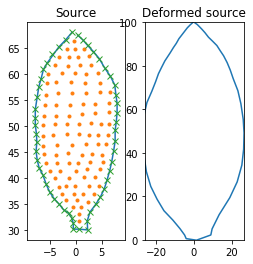

In [11]:
# Results
intermediate_states = intermediates['states']
deformed_source = intermediate_states[-1][0].gd
deformed_implicit0 = intermediate_states[-1][1].gd
#deformed_implicit0 = intermediate_states[-1][2].gd
#deformed_implicit1 = intermediate_states[-1][3].gd[0]

#%matplotlib qt5
plt.subplot(1, 3, 1)
plt.title("Source")
plt.axis(aabb.totuple())
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '-')
plt.plot(pos_implicit1[:, 0].numpy(), pos_implicit1[:, 1].numpy(), '.')
plt.plot(pos_implicit0[:, 0].numpy(), pos_implicit0[:, 1].numpy(), 'x')
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.axis(aabb.totuple())
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(deformed_implicit0[:, 0], deformed_implicit0[:, 1], 'x')
plt.plot(deformed_implicit1[:, 0], deformed_implicit1[:, 1], '.')
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.axis(aabb.totuple())
plt.plot(pos_target[:, 0].numpy(), pos_target[:, 1].numpy(), '-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.axis('equal')
plt.show()

In [12]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(model.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [13]:
intermediates_grid = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_method, shoot_it, intermediates=intermediates_grid)

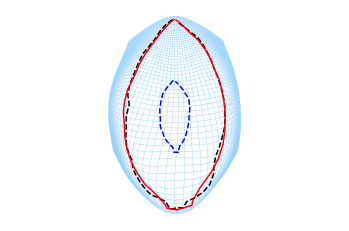

In [14]:
i=-1
f = plt.figure()
ax = f.add_subplot(1,1,1)
deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
deformation_grid_t.manifold.fill_gd(intermediates_grid['states'][i].gd[0].detach())
growth_deformed_grid_t = deformation_grid_t.togrid()
dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
plt.plot(pos_source.detach().numpy()[:,0], pos_source.detach().numpy()[:,1], '--b')
plt.plot(pos_target.detach().numpy()[:,0], pos_target.detach().numpy()[:,1], '--k')
plt.plot(intermediates_grid['states'][i].gd[1].detach().numpy()[:,0], intermediates_grid['states'][i].gd[1].detach().numpy()[:,1], 'r')
plt.axis('equal')
plt.axis('off')
plt.savefig('/home/gris/Results/ImplicitModules/Leaf/' + 'basipetal_deformationmodules.pdf', format='pdf', bbox_inches = 'tight')
#plt.savefig('/home/gris/Results/ImplicitModules/Leaf/' + 'basipetal_classiclargedformation.pdf', format='pdf', bbox_inches = 'tight')

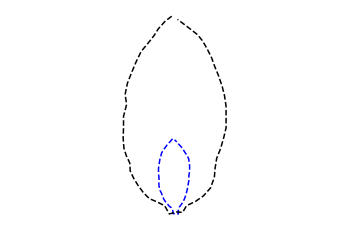

In [28]:
i=0
f = plt.figure()
ax = f.add_subplot(1,1,1)
deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
deformation_grid_t.manifold.fill_gd(intermediates_grid['states'][i].gd[0].detach())
growth_deformed_grid_t = deformation_grid_t.togrid()
#dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
plt.plot(pos_source.detach().numpy()[:,0], pos_source.detach().numpy()[:,1], '--b')
plt.plot(pos_target.detach().numpy()[:,0], pos_target.detach().numpy()[:,1], '--k')
#plt.plot(intermediates_grid['states'][i].gd[1].detach().numpy()[:,0], intermediates_grid['states'][i].gd[1].detach().numpy()[:,1], 'r')
plt.axis('equal')
plt.axis('off')
plt.savefig('/home/gris/Results/ImplicitModules/Leaf/' + 'basipetal_boundaries.pdf', format='pdf', bbox_inches = 'tight')

In [142]:
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)

intermediate_states, intermediate_controls = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(modules), shoot_it, shoot_method, intermediates=True)

implicit0_controls = [control[2] for control in intermediate_controls]
implicit1_controls = [control[3] for control in intermediate_controls]

print(implicit1_controls)

[tensor([-0.0180]), tensor([0.0365]), tensor([0.0865]), tensor([0.1399]), tensor([0.2030]), tensor([0.2786]), tensor([0.3508]), tensor([0.3607]), tensor([0.3003]), tensor([0.2561])]


In [149]:
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)

silent = copy.copy(modules[0])
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(pos_source).scale(1.2), [32, 32])
implicit1 = copy.copy(modules[3])

# silent.manifold.fill(model.init_manifold[0], copy=True)
# silent.manifold.fill_cotan_zeros()
# implicit0.manifold.fill(model.init_manifold[3], copy=True)
# implicit1.manifold.fill_cotan_zeros()

controls = [[torch.tensor([]), torch.tensor([]), control] for control in implicit1_controls]

dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([silent, deformation_grid, implicit1]), shoot_it, shoot_method, controls=controls)

deformed_source = silent.manifold.gd.detach()
deformed_grid = deformation_grid.togrid()
deformed_implicit1 = implicit1.manifold.gd[0].detach()

ax = plt.subplot()
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '--', color='black')
plt.plot(deformed_source[:, 0].numpy(), deformed_source[:, 1].numpy(), '-', color='black')
dm.Utilities.plot_grid(ax, deformed_grid[0], deformed_grid[1], color='xkcd:light blue', lw=0.5)
plt.plot(deformed_implicit1[:, 0].numpy(), deformed_implicit1[:, 1].numpy(), 'x')
plt.axis('equal')
plt.show()

In [155]:
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)

silent = copy.copy(modules[0])
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(pos_source).scale(1.2), [32, 32])
implicit0 = copy.copy(modules[2])

controls = [[torch.tensor([]), torch.tensor([]), control] for control in implicit0_controls]

dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([silent, deformation_grid, implicit0]), shoot_it, shoot_method, controls=controls)

deformed_source = silent.manifold.gd.detach()
deformed_grid = deformation_grid.togrid()
deformed_implicit0 = implicit0.manifold.gd.detach()

ax = plt.subplot()
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '--', color='black')
plt.plot(deformed_source[:, 0].numpy(), deformed_source[:, 1].numpy(), '-', color='black')
dm.Utilities.plot_grid(ax, deformed_grid[0], deformed_grid[1], color='xkcd:light blue', lw=0.5)
plt.plot(deformed_implicit0[:, 0].numpy(), deformed_implicit0[:, 1].numpy(), 'x')
plt.axis('equal')
plt.show()